# Bonus1: Parallel Algorithms

### Name: Ryan Adoni


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [450]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [451]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [452]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.11355441 -0.17310362  0.07070995 -0.01821492 -0.1317914   0.11036109
  -0.16703078  0.03603103]]
test std = 
[[0.93765264 1.05301131 0.84254614 1.05853505 0.84747412 0.96877429
  1.00588543 0.99973933]]


## 1.4. Add a dimension of all ones

In [453]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


##  Worker Node Definition

In [454]:
# Worker class defined in the pdf given to us.  Originally for AGD, I am adapting it for GD and SGD
class Worker:
    def __init__(self, x, y):
        self.x = x # s−by−d local feature matrix
        self.y = y # s−by−1 local label matrix
        self.s = x.shape[0] # number of local samples
        self.d = x.shape[1] # number of features
        self.w = numpy.zeros((d, 1)) # d−by−1 model parameter vector
        self.w0 = numpy.zeros((d, 1)) # d−by−1 model parameter vector

    # Set the model parameters to the latest
    def set_param(self, w):
        self.w = w
        self.w0 = w # must add this to calculate p
    
    # Compute the local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix
        yxw = numpy.dot(yx, self.w) # s−by−1 matrix
        vec1 = numpy.exp(-yxw) # s−by−1 matrix
        vec2 = numpy.log(1 + vec1) # s−by−1 matrix
        return numpy.sum(vec2) # loss function
    
    # Compute the local gradient
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix
        yxw = numpy.dot(yx, self.w) # s−by−1 matrix
        vec1 = numpy.exp(yxw) # s−by−1 matrix
        vec2 = numpy.divide(yx, 1 + vec1) # s−by−d matrix
        g = -numpy.sum(vec2, axis = 0).reshape(self.d, 1) # d−by−1 matrix
        return g
    
    # compute stochastic gradient (from hw2 basically without regularizer)
    def stochastic_objective_gradient(self, xi, yi):
        yx = yi * xi # 1-by-d matrix
        yxw = float(numpy.dot(yx, self.w)) # scalar
        
        # calculate objective function Q_i
        loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
        
        # calculate stochastic gradient
        g = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
        
        return g, loss

    # from my hw2 with minor edits
    def gd(self, stepsize, max_iter):
        for t in range(max_iter):
            g = self.gradient()
            self.w -= stepsize * g   
        return self.w0 - self.w, self.loss()
    
    # from my hw2 with minor edits
    def sgd(self, stepsize, max_epoch = 100):
        # w0 = self.w # before creating new variable.  
        for t in range(max_epoch):
            # randomly shuffle the samples
            rand_indices = numpy.random.permutation(self.s)
            x_rand = self.x[rand_indices, :]
            y_rand = self.y[rand_indices, :]
            
            objval = 0 # accumulate the objective values
            for i in range(self.s):
                xi = x_rand[i, :] # 1-by-d matrix
                yi = float(y_rand[i, :]) # scalar
                g, loss = self.stochastic_objective_gradient(xi, yi)
                objval += loss
                self.w -= stepsize * g   
        return self.w0 - self.w, objval # p in pdf

## Server Definition

In [455]:
# Server class defined in the pdf given to us.  Originally for AGD, I am adapting it for GD and SGD
class Server:
    def __init__(self, m, n, d):
        self.m = m # number of worker nodes
        self.n = n # number of training samples
        self.d = d # number of features
        self.w = numpy.zeros((d, 1)) # d−by−1 model parameter vector
        self.g = 0
        self.v = numpy.zeros((d, 1)) # d−by−1 momentum # for AGD
        self.loss = 0 # loss function value
        self.obj = 0 # objective function value

    def broadcast(self):
        return self.w

    # Sum the gradients and loss functions evaluated by the workers
    # Args:
    #   grads: a list of d−by−1 vectors
    #   losses: a list of scalars
    def aggregate(self, grads, losses):
        self.g = 0
        self.loss = 0
        for k in range(self.m):
            self.g += grads[k]
            self.loss += losses[k]
        self.g /= self.m

    # Compute the gradient (from the loss and regularization)
    def gradient(self, lam):
        self.g = self.g / self.n + lam * self.w

    # Compute the objective function (sum of loss and regularization)
    def objective(self, lam):
        reg = lam / 2 * numpy.sum(self.w * self.w)
        self.obj = self.loss / self.n + reg
        return self.obj

    # Update the model parameters using accelerated gradient descent
    # Args:
    #   alpha: learning rate (step size)
    #   beta: momentum parameter
    def agd(self, alpha, beta):
        self.v *= beta
        self.v += self.g
        self.w -= alpha * self.v

    # Update the model parameters using gradient descent
    # Args:
    #   alpha: learning rate (step size)
    def gd(self, alpha):
        self.w -= alpha * self.g


## Initialization

In [456]:
import math

# Create a server and m worker nodes
def create_server_workers(m, x, y):
    n, d = x.shape
    s = math.floor( n / m)
    server = Server(m, n, d)
    workers = []

    for i in range(m):
        indices = list(range(i * s, (i + 1) * s))
        worker = Worker(x[indices, :], y[indices, :])
        workers.append(worker)

    return server, workers

## Parallel Gradient Descent and Parallel Stochastic Gradient Descent Function (Federated Averaging if q > 1)

In [457]:
def parallel_GD(lam, alpha, max_epoch, q, method):
    # beta = 0.9 # momentum parameter # from AGD

    objs = []

    for t in range(max_epoch):
        # step 1: broadcast
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)

        # step 2: workers’ local computations
        grads = []
        losses = []

        for i in range(m):
            if(method == "GD"):
                g, l = workers[i].gd(alpha, q)
            elif(method == "SGD"):
                g, l = workers[i].sgd(alpha, q)
            else:
                return [] # failed
            grads.append(g)
            losses.append(l)

        # step 3: aggregate the workers’ outputs
        server.aggregate(grads, losses)

        # step 4: server update the model parameters
        server.gradient(lam) # compute gradient
        obj = server.objective(lam) # compute objective function
        objs.append(obj) # apend obj to list
        print("Objective function value = " + str(obj))
        server.gd(alpha) # updates the model parameters # changed this from AGD to GD/SGD 
    return objs

In [458]:
lam = 1E-6 # regularization parameter
alpha = 1E-3 # learning rate
max_epoch = 50 # number of epochs
m = 4 # number o f worker nodes

print("GD q = 1")
server, workers = create_server_workers(m, x_train, y_train)
objs_gd1 = parallel_GD(lam, alpha, max_epoch, 1, "GD")

print("GD q = 8")
server, workers = create_server_workers(m, x_train, y_train)
objs_gd8 = parallel_GD(lam, alpha, max_epoch, 8, "GD")

print("SGD q = 1")
server, workers = create_server_workers(m, x_train, y_train)
objs_sgd1 = parallel_GD(lam, alpha, max_epoch, 1, "SGD")

print("SGD q = 8")
server, workers = create_server_workers(m, x_train, y_train)
objs_sgd8 = parallel_GD(lam, alpha, max_epoch, 8, "SGD")

GD q = 1
Objective function value = 0.6443821534171836
Objective function value = 0.5928180861815485
Objective function value = 0.5606196271602303
Objective function value = 0.5389837670281845
Objective function value = 0.5235708863144343
Objective function value = 0.5120932615829623
Objective function value = 0.5032543999512215
Objective function value = 0.49627053965408574
Objective function value = 0.49064103449388924
Objective function value = 0.48603088450819243
Objective function value = 0.48220702197685605
Objective function value = 0.47900191431650346
Objective function value = 0.47629179664034366
Objective function value = 0.47398311388544767
Objective function value = 0.4720037659181171
Objective function value = 0.4702972697953448
Objective function value = 0.46881875470335627
Objective function value = 0.46753214402999366
Objective function value = 0.46640812801885817
Objective function value = 0.4654226762735619
Objective function value = 0.4645559273188616
Objective funct

## compare SGD and GD at q = 1 and q = 8

C:\Users\Stevens User\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':
C:\Users\Stevens User\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  del sys.path[0]
C:\Users\Stevens User\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
C:\Users\Stevens User\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

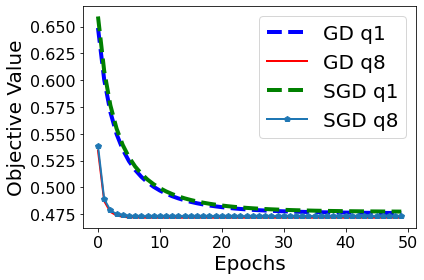

In [449]:

# copied this from hw2
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd1 = range(len(objs_gd1))
epochs_gd8 = range(len(objs_gd8))
epochs_sgd1 = range(len(objs_sgd1))
epochs_sgd8 = range(len(objs_sgd8))

line0, = plt.plot(epochs_gd1, objs_gd1, '--b', LineWidth = 4)
line1, = plt.plot(epochs_gd8, objs_gd8, '-r', LineWidth = 2)
line2, = plt.plot(epochs_sgd1, objs_sgd1, '--g', LineWidth = 4)
line3, = plt.plot(epochs_sgd8, objs_sgd8, '-p', LineWidth = 2)

plt.xlabel('Number of Communications', FontSize = 20)
plt.ylabel('Objective Value', FontSize = 20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD q1', 'GD q8', 'SGD q1', 'SGD q8'], fontsize = 20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)